## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)
"""Code Here
建立實驗的比較組合

factor: 學習速率被降低的因數。新的學習速率 = 學習速率 * 因數
patience: 沒有進步的訓練輪數，在這之後訓練速率會被降低。
"""
reduce_lr_factor = [0.1,0.3,0.5,0.7]
redice_lr_patient = [3,5,7,9,10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 3
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
bat

49/49 [==============================] - 1s 30ms/step - loss: 1.5307 - accuracy: 0.4673 - val_loss: 1.6608 - val_accuracy: 0.4289 - lr: 1.0000e-04
Numbers of exp: 3, reduce_factor: 0.10, reduce_patient: 9
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
____________________________________________________

49/49 [==============================] - 1s 28ms/step - loss: 1.5276 - accuracy: 0.4679 - val_loss: 1.6564 - val_accuracy: 0.4237 - lr: 1.0000e-04
Numbers of exp: 6, reduce_factor: 0.30, reduce_patient: 5
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_18 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
____________________________________________________

49/49 [==============================] - 1s 27ms/step - loss: 1.5314 - accuracy: 0.4657 - val_loss: 1.6548 - val_accuracy: 0.4278 - lr: 1.0000e-04
Numbers of exp: 9, reduce_factor: 0.30, reduce_patient: 10
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_27 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_28 (Batc (None, 256)               1024      
___________________________________________________

49/49 [==============================] - 1s 28ms/step - loss: 1.5466 - accuracy: 0.4628 - val_loss: 1.6472 - val_accuracy: 0.4247 - lr: 1.0000e-04
Numbers of exp: 12, reduce_factor: 0.50, reduce_patient: 7
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_36 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_37 (Batc (None, 256)               1024      
__________________________________________________

49/49 [==============================] - 1s 28ms/step - loss: 1.5319 - accuracy: 0.4635 - val_loss: 1.6559 - val_accuracy: 0.4197 - lr: 1.0000e-04
Numbers of exp: 15, reduce_factor: 0.70, reduce_patient: 3
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_45 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
__________________________________________________

49/49 [==============================] - 1s 31ms/step - loss: 1.5395 - accuracy: 0.4606 - val_loss: 1.6644 - val_accuracy: 0.4124 - lr: 1.0000e-04
Numbers of exp: 18, reduce_factor: 0.70, reduce_patient: 9
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_54 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_55 (Batc (None, 256)               1024      
__________________________________________________

Epoch 23/25
49/49 [==============================] - 1s 28ms/step - loss: 0.7798 - accuracy: 0.7425 - val_loss: 1.3072 - val_accuracy: 0.5464 - lr: 1.0000e-06
Epoch 24/25
49/49 [==============================] - 1s 29ms/step - loss: 0.7803 - accuracy: 0.7414 - val_loss: 1.3079 - val_accuracy: 0.5465 - lr: 1.0000e-06
Epoch 25/25
49/49 [==============================] - ETA: 0s - loss: 0.7804 - accuracy: 0.7424
Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
49/49 [==============================] - 1s 28ms/step - loss: 0.7804 - accuracy: 0.7424 - val_loss: 1.3084 - val_accuracy: 0.5472 - lr: 1.0000e-06
Numbers of exp: 21, reduce_factor: 0.10, reduce_patient: 5
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Den

Epoch 1/25
49/49 [==============================] - 3s 52ms/step - loss: 3.1037 - accuracy: 0.1009 - val_loss: 2.3654 - val_accuracy: 0.1079 - lr: 1.0000e-11
Epoch 2/25
49/49 [==============================] - 2s 38ms/step - loss: 3.1039 - accuracy: 0.1006 - val_loss: 2.4332 - val_accuracy: 0.1034 - lr: 1.0000e-11
Epoch 3/25
49/49 [==============================] - 2s 35ms/step - loss: 3.1020 - accuracy: 0.1003 - val_loss: 2.5387 - val_accuracy: 0.0973 - lr: 1.0000e-11
Epoch 4/25
49/49 [==============================] - 2s 38ms/step - loss: 3.1046 - accuracy: 0.1003 - val_loss: 2.6363 - val_accuracy: 0.0957 - lr: 1.0000e-11
Epoch 5/25
49/49 [==============================] - 2s 47ms/step - loss: 3.1027 - accuracy: 0.0997 - val_loss: 2.7142 - val_accuracy: 0.0945 - lr: 1.0000e-11
Epoch 6/25
49/49 [==============================] - 2s 44ms/step - loss: 3.1036 - accuracy: 0.1004 - val_loss: 2.7738 - val_accuracy: 0.0930 - lr: 1.0000e-11
Epoch 7/25
49/49 [==============================] - 

Epoch 1/25
49/49 [==============================] - 3s 64ms/step - loss: 2.9598 - accuracy: 0.1048 - val_loss: 2.3031 - val_accuracy: 0.1257 - lr: 1.0000e-12
Epoch 2/25
49/49 [==============================] - 2s 49ms/step - loss: 2.9596 - accuracy: 0.1046 - val_loss: 2.3483 - val_accuracy: 0.0894 - lr: 1.0000e-12
Epoch 3/25
49/49 [==============================] - 1s 28ms/step - loss: 2.9592 - accuracy: 0.1048 - val_loss: 2.4097 - val_accuracy: 0.0844 - lr: 1.0000e-12
Epoch 4/25
49/49 [==============================] - 2s 32ms/step - loss: 2.9600 - accuracy: 0.1057 - val_loss: 2.4655 - val_accuracy: 0.0905 - lr: 1.0000e-12
Epoch 5/25
49/49 [==============================] - 2s 38ms/step - loss: 2.9594 - accuracy: 0.1045 - val_loss: 2.5184 - val_accuracy: 0.0918 - lr: 1.0000e-12
Epoch 6/25
49/49 [==============================] - 1s 27ms/step - loss: 2.9592 - accuracy: 0.1054 - val_loss: 2.5714 - val_accuracy: 0.0948 - lr: 1.0000e-12
Epoch 7/25
49/49 [==============================] - 

49/49 [==============================] - 1s 31ms/step - loss: 3.0551 - accuracy: 0.0956 - val_loss: 2.3808 - val_accuracy: 0.0915 - lr: 1.0000e-12
Epoch 2/25
49/49 [==============================] - 1s 28ms/step - loss: 3.0554 - accuracy: 0.0964 - val_loss: 2.4216 - val_accuracy: 0.0867 - lr: 1.0000e-12
Epoch 3/25
49/49 [==============================] - 1s 29ms/step - loss: 3.0557 - accuracy: 0.0957 - val_loss: 2.4723 - val_accuracy: 0.0872 - lr: 1.0000e-12
Epoch 4/25
49/49 [==============================] - 1s 28ms/step - loss: 3.0555 - accuracy: 0.0955 - val_loss: 2.5267 - val_accuracy: 0.0875 - lr: 1.0000e-12
Epoch 5/25
49/49 [==============================] - 1s 28ms/step - loss: 3.0541 - accuracy: 0.0961 - val_loss: 2.5871 - val_accuracy: 0.0890 - lr: 1.0000e-12
Epoch 6/25
49/49 [==============================] - 1s 28ms/step - loss: 3.0556 - accuracy: 0.0966 - val_loss: 2.6546 - val_accuracy: 0.0886 - lr: 1.0000e-12
Epoch 7/25
49/49 [==============================] - 1s 28ms/ste

49/49 [==============================] - 2s 33ms/step - loss: 3.1903 - accuracy: 0.0871 - val_loss: 2.3756 - val_accuracy: 0.0747 - lr: 1.0000e-12
Epoch 2/25
49/49 [==============================] - 1s 28ms/step - loss: 3.1908 - accuracy: 0.0872 - val_loss: 2.4023 - val_accuracy: 0.0904 - lr: 1.0000e-12
Epoch 3/25
49/49 [==============================] - 1s 28ms/step - loss: 3.1902 - accuracy: 0.0875 - val_loss: 2.4663 - val_accuracy: 0.0929 - lr: 1.0000e-12
Epoch 4/25
49/49 [==============================] - 1s 28ms/step - loss: 3.1899 - accuracy: 0.0882 - val_loss: 2.5441 - val_accuracy: 0.0908 - lr: 1.0000e-12
Epoch 5/25
49/49 [==============================] - 1s 28ms/step - loss: 3.1903 - accuracy: 0.0877 - val_loss: 2.6279 - val_accuracy: 0.0868 - lr: 1.0000e-12
Epoch 6/25
49/49 [==============================] - 1s 29ms/step - loss: 3.1903 - accuracy: 0.0879 - val_loss: 2.7139 - val_accuracy: 0.0815 - lr: 1.0000e-12
Epoch 7/25
49/49 [==============================] - 1s 28ms/ste

49/49 [==============================] - 3s 61ms/step - loss: 3.0938 - accuracy: 0.0938 - val_loss: 2.3729 - val_accuracy: 0.0843 - lr: 1.0000e-12
Epoch 2/25
49/49 [==============================] - 1s 28ms/step - loss: 3.0920 - accuracy: 0.0948 - val_loss: 2.4123 - val_accuracy: 0.0735 - lr: 1.0000e-12
Epoch 3/25
49/49 [==============================] - 1s 29ms/step - loss: 3.0934 - accuracy: 0.0941 - val_loss: 2.4725 - val_accuracy: 0.0766 - lr: 1.0000e-12
Epoch 4/25
49/49 [==============================] - 1s 30ms/step - loss: 3.0934 - accuracy: 0.0948 - val_loss: 2.5435 - val_accuracy: 0.0769 - lr: 1.0000e-12
Epoch 5/25
49/49 [==============================] - 1s 30ms/step - loss: 3.0933 - accuracy: 0.0941 - val_loss: 2.6204 - val_accuracy: 0.0811 - lr: 1.0000e-12
Epoch 6/25
49/49 [==============================] - 1s 29ms/step - loss: 3.0929 - accuracy: 0.0941 - val_loss: 2.6981 - val_accuracy: 0.0844 - lr: 1.0000e-12
Epoch 7/25
49/49 [==============================] - 1s 29ms/ste

49/49 [==============================] - 2s 33ms/step - loss: 3.0161 - accuracy: 0.1070 - val_loss: 2.3427 - val_accuracy: 0.0964 - lr: 1.0000e-12
Epoch 2/25
49/49 [==============================] - 1s 28ms/step - loss: 3.0155 - accuracy: 0.1075 - val_loss: 2.3594 - val_accuracy: 0.1094 - lr: 1.0000e-12
Epoch 3/25
49/49 [==============================] - 1s 29ms/step - loss: 3.0172 - accuracy: 0.1067 - val_loss: 2.4077 - val_accuracy: 0.1081 - lr: 1.0000e-12
Epoch 4/25
49/49 [==============================] - 1s 29ms/step - loss: 3.0165 - accuracy: 0.1066 - val_loss: 2.4703 - val_accuracy: 0.1071 - lr: 1.0000e-12
Epoch 5/25
49/49 [==============================] - 1s 29ms/step - loss: 3.0160 - accuracy: 0.1062 - val_loss: 2.5389 - val_accuracy: 0.1077 - lr: 1.0000e-12
Epoch 6/25
49/49 [==============================] - 1s 29ms/step - loss: 3.0170 - accuracy: 0.1066 - val_loss: 2.6090 - val_accuracy: 0.1069 - lr: 1.0000e-12
Epoch 7/25
49/49 [==============================] - 1s 29ms/ste

49/49 [==============================] - 2s 38ms/step - loss: 1.7991 - accuracy: 0.3719 - val_loss: 2.0733 - val_accuracy: 0.2783 - lr: 0.0010
Epoch 2/25
49/49 [==============================] - 2s 32ms/step - loss: 1.5318 - accuracy: 0.4605 - val_loss: 2.0127 - val_accuracy: 0.3010 - lr: 0.0010
Epoch 3/25
49/49 [==============================] - 2s 32ms/step - loss: 1.4359 - accuracy: 0.4910 - val_loss: 1.9037 - val_accuracy: 0.3700 - lr: 0.0010
Epoch 4/25
49/49 [==============================] - 2s 33ms/step - loss: 1.3622 - accuracy: 0.5171 - val_loss: 1.8969 - val_accuracy: 0.3356 - lr: 0.0010
Epoch 5/25
49/49 [==============================] - 2s 32ms/step - loss: 1.2944 - accuracy: 0.5432 - val_loss: 2.5052 - val_accuracy: 0.2283 - lr: 0.0010
Epoch 6/25
49/49 [==============================] - 2s 32ms/step - loss: 1.2438 - accuracy: 0.5588 - val_loss: 2.1060 - val_accuracy: 0.3063 - lr: 0.0010
Epoch 7/25
49/49 [==============================] - 2s 33ms/step - loss: 1.1909 - accur

Epoch 17/25
49/49 [==============================] - 2s 33ms/step - loss: 1.4863 - accuracy: 0.4837 - val_loss: 1.6402 - val_accuracy: 0.4282 - lr: 1.0000e-05
Epoch 18/25
49/49 [==============================] - 2s 33ms/step - loss: 1.4711 - accuracy: 0.4915 - val_loss: 1.6293 - val_accuracy: 0.4351 - lr: 1.0000e-05
Epoch 19/25
49/49 [==============================] - 2s 33ms/step - loss: 1.4576 - accuracy: 0.4946 - val_loss: 1.6243 - val_accuracy: 0.4364 - lr: 1.0000e-05
Epoch 20/25
49/49 [==============================] - 2s 33ms/step - loss: 1.4424 - accuracy: 0.4997 - val_loss: 1.6150 - val_accuracy: 0.4384 - lr: 1.0000e-05
Epoch 21/25
49/49 [==============================] - 2s 33ms/step - loss: 1.4304 - accuracy: 0.5041 - val_loss: 1.6097 - val_accuracy: 0.4381 - lr: 1.0000e-05
Epoch 22/25
49/49 [==============================] - 2s 34ms/step - loss: 1.4167 - accuracy: 0.5085 - val_loss: 1.6031 - val_accuracy: 0.4410 - lr: 1.0000e-05
Epoch 23/25
49/49 [===========================

Epoch 1/25
49/49 [==============================] - 2s 48ms/step - loss: 2.4787 - accuracy: 0.1997 - val_loss: 2.2061 - val_accuracy: 0.2022 - lr: 1.0000e-05
Epoch 2/25
49/49 [==============================] - 2s 32ms/step - loss: 2.1345 - accuracy: 0.2793 - val_loss: 2.1073 - val_accuracy: 0.2471 - lr: 1.0000e-05
Epoch 3/25
49/49 [==============================] - 2s 33ms/step - loss: 1.9864 - accuracy: 0.3203 - val_loss: 2.0136 - val_accuracy: 0.2808 - lr: 1.0000e-05
Epoch 4/25
49/49 [==============================] - 2s 33ms/step - loss: 1.8920 - accuracy: 0.3482 - val_loss: 1.9258 - val_accuracy: 0.3123 - lr: 1.0000e-05
Epoch 5/25
49/49 [==============================] - 2s 33ms/step - loss: 1.8221 - accuracy: 0.3686 - val_loss: 1.8426 - val_accuracy: 0.3469 - lr: 1.0000e-05
Epoch 6/25
49/49 [==============================] - 2s 33ms/step - loss: 1.7711 - accuracy: 0.3857 - val_loss: 1.7942 - val_accuracy: 0.3698 - lr: 1.0000e-05
Epoch 7/25
49/49 [==============================] - 

49/49 [==============================] - 2s 35ms/step - loss: 2.5167 - accuracy: 0.1996 - val_loss: 2.2029 - val_accuracy: 0.1812 - lr: 1.0000e-05
Epoch 2/25
49/49 [==============================] - 2s 33ms/step - loss: 2.1777 - accuracy: 0.2739 - val_loss: 2.1257 - val_accuracy: 0.2292 - lr: 1.0000e-05
Epoch 3/25
49/49 [==============================] - 2s 33ms/step - loss: 2.0207 - accuracy: 0.3134 - val_loss: 2.0537 - val_accuracy: 0.2569 - lr: 1.0000e-05
Epoch 4/25
49/49 [==============================] - 2s 33ms/step - loss: 1.9234 - accuracy: 0.3413 - val_loss: 1.9532 - val_accuracy: 0.3023 - lr: 1.0000e-05
Epoch 5/25
49/49 [==============================] - 2s 33ms/step - loss: 1.8529 - accuracy: 0.3627 - val_loss: 1.8887 - val_accuracy: 0.3296 - lr: 1.0000e-05
Epoch 6/25
49/49 [==============================] - 2s 35ms/step - loss: 1.7996 - accuracy: 0.3784 - val_loss: 1.8311 - val_accuracy: 0.3553 - lr: 1.0000e-05
Epoch 7/25
49/49 [==============================] - 2s 33ms/ste

49/49 [==============================] - 2s 35ms/step - loss: 2.4785 - accuracy: 0.1988 - val_loss: 2.2331 - val_accuracy: 0.1464 - lr: 1.0000e-05
Epoch 2/25
49/49 [==============================] - 2s 33ms/step - loss: 2.1490 - accuracy: 0.2814 - val_loss: 2.1553 - val_accuracy: 0.1892 - lr: 1.0000e-05
Epoch 3/25
49/49 [==============================] - 2s 33ms/step - loss: 1.9996 - accuracy: 0.3220 - val_loss: 2.0634 - val_accuracy: 0.2461 - lr: 1.0000e-05
Epoch 4/25
49/49 [==============================] - 2s 33ms/step - loss: 1.9017 - accuracy: 0.3482 - val_loss: 1.9723 - val_accuracy: 0.2988 - lr: 1.0000e-05
Epoch 5/25
49/49 [==============================] - 2s 33ms/step - loss: 1.8334 - accuracy: 0.3684 - val_loss: 1.8799 - val_accuracy: 0.3420 - lr: 1.0000e-05
Epoch 6/25
49/49 [==============================] - 2s 33ms/step - loss: 1.7805 - accuracy: 0.3843 - val_loss: 1.8254 - val_accuracy: 0.3661 - lr: 1.0000e-05
Epoch 7/25
49/49 [==============================] - 2s 33ms/ste

49/49 [==============================] - 2s 35ms/step - loss: 2.5580 - accuracy: 0.1802 - val_loss: 2.2572 - val_accuracy: 0.1727 - lr: 1.0000e-05
Epoch 2/25
49/49 [==============================] - 2s 33ms/step - loss: 2.1935 - accuracy: 0.2670 - val_loss: 2.1873 - val_accuracy: 0.1869 - lr: 1.0000e-05
Epoch 3/25
49/49 [==============================] - 2s 32ms/step - loss: 2.0298 - accuracy: 0.3105 - val_loss: 2.0964 - val_accuracy: 0.2377 - lr: 1.0000e-05
Epoch 4/25
49/49 [==============================] - 2s 33ms/step - loss: 1.9257 - accuracy: 0.3417 - val_loss: 2.0000 - val_accuracy: 0.2885 - lr: 1.0000e-05
Epoch 5/25
49/49 [==============================] - 2s 33ms/step - loss: 1.8529 - accuracy: 0.3616 - val_loss: 1.9173 - val_accuracy: 0.3244 - lr: 1.0000e-05
Epoch 6/25
49/49 [==============================] - 2s 34ms/step - loss: 1.7964 - accuracy: 0.3784 - val_loss: 1.8488 - val_accuracy: 0.3465 - lr: 1.0000e-05
Epoch 7/25
49/49 [==============================] - 2s 32ms/ste

49/49 [==============================] - 2s 36ms/step - loss: 2.6884 - accuracy: 0.1689 - val_loss: 2.2155 - val_accuracy: 0.1805 - lr: 1.0000e-05
Epoch 2/25
49/49 [==============================] - 2s 33ms/step - loss: 2.2668 - accuracy: 0.2494 - val_loss: 2.1768 - val_accuracy: 0.1924 - lr: 1.0000e-05
Epoch 3/25
49/49 [==============================] - 2s 33ms/step - loss: 2.0730 - accuracy: 0.2990 - val_loss: 2.1477 - val_accuracy: 0.2103 - lr: 1.0000e-05
Epoch 4/25
49/49 [==============================] - 2s 33ms/step - loss: 1.9571 - accuracy: 0.3339 - val_loss: 2.0585 - val_accuracy: 0.2482 - lr: 1.0000e-05
Epoch 5/25
49/49 [==============================] - 2s 33ms/step - loss: 1.8789 - accuracy: 0.3569 - val_loss: 1.9565 - val_accuracy: 0.2986 - lr: 1.0000e-05
Epoch 6/25
49/49 [==============================] - 2s 33ms/step - loss: 1.8182 - accuracy: 0.3751 - val_loss: 1.8759 - val_accuracy: 0.3411 - lr: 1.0000e-05
Epoch 7/25
49/49 [==============================] - 2s 33ms/ste

49/49 [==============================] - 2s 36ms/step - loss: 2.4950 - accuracy: 0.1992 - val_loss: 2.1997 - val_accuracy: 0.1996 - lr: 1.0000e-05
Epoch 2/25
49/49 [==============================] - 2s 32ms/step - loss: 2.1567 - accuracy: 0.2751 - val_loss: 2.1208 - val_accuracy: 0.2351 - lr: 1.0000e-05
Epoch 3/25
49/49 [==============================] - 2s 33ms/step - loss: 2.0039 - accuracy: 0.3163 - val_loss: 2.0382 - val_accuracy: 0.2656 - lr: 1.0000e-05
Epoch 4/25
49/49 [==============================] - 2s 33ms/step - loss: 1.9091 - accuracy: 0.3427 - val_loss: 1.9475 - val_accuracy: 0.2945 - lr: 1.0000e-05
Epoch 5/25
49/49 [==============================] - 2s 33ms/step - loss: 1.8376 - accuracy: 0.3640 - val_loss: 1.8724 - val_accuracy: 0.3280 - lr: 1.0000e-05
Epoch 6/25
49/49 [==============================] - 2s 33ms/step - loss: 1.7838 - accuracy: 0.3828 - val_loss: 1.8090 - val_accuracy: 0.3528 - lr: 1.0000e-05
Epoch 7/25
49/49 [==============================] - 2s 33ms/ste

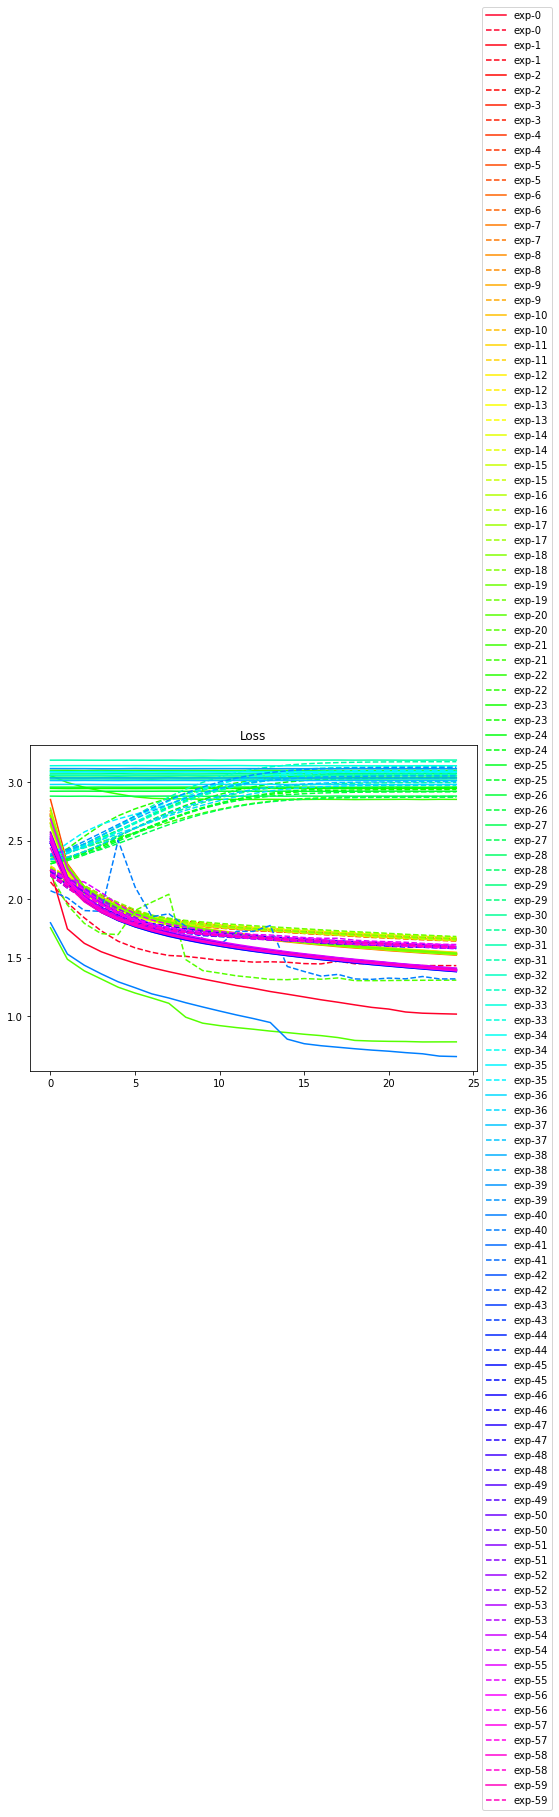

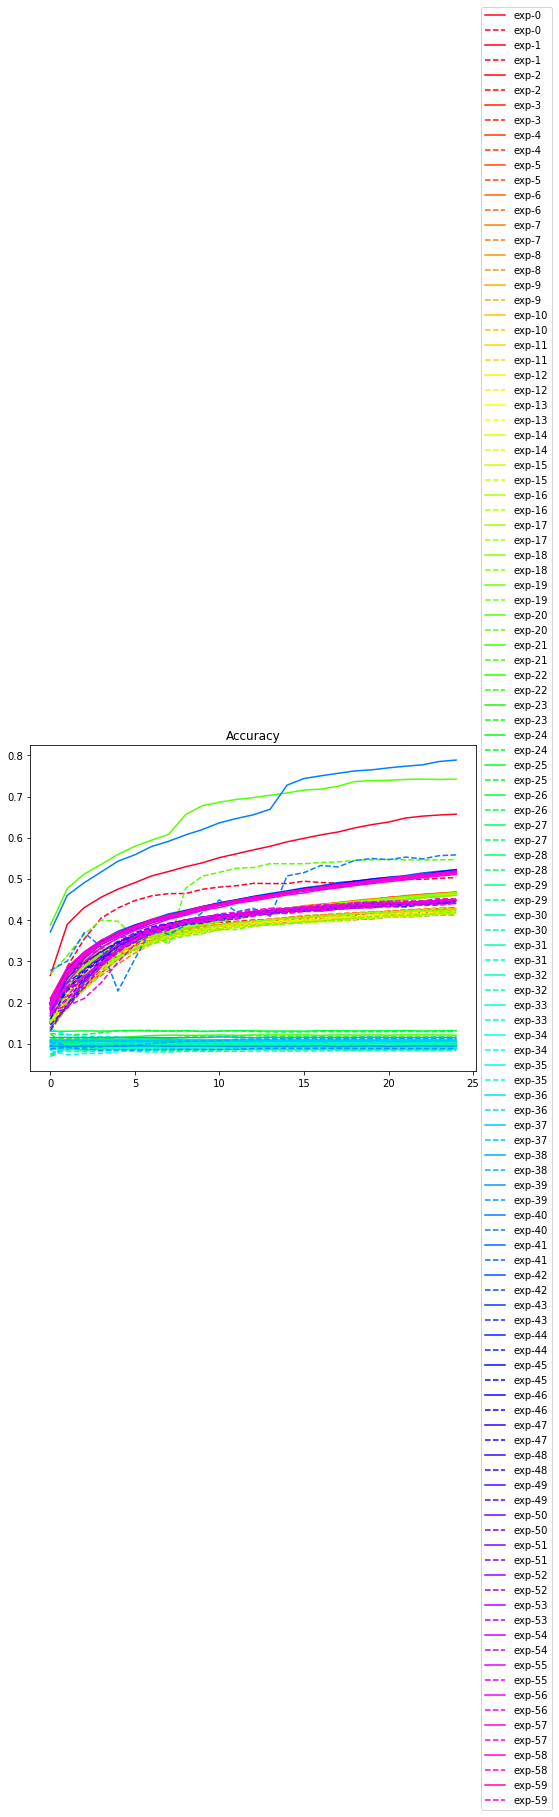

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
'''
當reduce_factor: 0.10, reduce_patient:3 (exp: 40) 時，訓練集、測試集準確率為最高，0.7885、0.5585。
'''